Copilot: Ok now let me explain to you a little bit more about this project. Those csv files are event data, it is a type of data provided by event based sensor, sensors that triggers with the change of luminosity in a scene. It is used in the industry for application when a high refresh rate is needed, since it can notice up to 1 million event per second. Regarding the information structure, an event is a tuple of lenght 4:  (x, y, p, t) where (x,y) represents the pixel where the event occurs, p: bool (0 or 1) wether the event was an increas or a decrease of the luminosity, and t the timestamp (in micro-seconds, since begining of the footage). An event data is a dataframe where rows are events, increasingly with respect to the timestamp, so a dataframe of up to hundreds of thousands of rows, and 4 columns.

I want to classify those events, do u have any suggestions?

***

# Event Lip Reading

**Author**: Adly Zaroui

The "Event Lip Reading" project aims to develop a system that can recognize and interpret lip movements from event-based sensor data. Event-based sensors are capable of capturing high-frequency changes in luminosity, making them ideal for applications that require a high refresh rate. In this project, the event data consists of tuples containing the pixel coordinates, polarity (increase or decrease in luminosity), and timestamp of each event.

The goal of the project is to classify these events and extract meaningful information from them. This can be achieved by aggregating the events into superframes, converting them into images, and applying various image processing techniques. The project involves tasks such as loading the event data, converting events to images, creating animations from the images, and aggregating events into superframes.

By analyzing the lip movements captured by the event-based sensor, the system can potentially be used for lip reading applications, speech recognition, and other related tasks. The project utilizes Python, pandas, numpy, matplotlib, and other libraries to process and visualize the event data.

To analyze event data, there is mainly 2 ways: the first one is to convert the events into conventional video data (sequence of images - sequence of matrices of pixels values) then apply conventional video classification algorithms. The first path that we will dive into is to treat event data as they are: multivariate time series, then explore classification techniques on mulitvariate time series.

***

First, let's define a function that loads the data and then use it to load he data:

In [1]:
import os
import pandas as pd
from tqdm import tqdm # for tracking progress

def load_data(base_path, class_folders=None):
    '''
    
    Loads the data from the specified base path.
    
    Parameters:
        base_path (str): The base path to the data.
        class_folders (list): The list of class folders names to load.
        
    Returns:
        dataframes (dict): A dictionary of dataframes.
    
    '''
    
    # Initialize a dictionary to hold dataframes
    dataframes = {}

    if class_folders:
        # Loop over each class folder
        for folder in tqdm(class_folders):
            # Initialize a list to hold dataframes for this class
            dataframes[folder] = []
            
            # Get the list of CSV files in this class folder
            csv_files = os.listdir(os.path.join(base_path, folder))
            
            # Loop over each CSV file
            for csv_file in csv_files:
                # Define the full path to the CSV file
                csv_path = os.path.join(base_path, folder, csv_file)
                
                # Load the CSV file into a dataframe
                df = pd.read_csv(csv_path)
                
                # Append the dataframe to the list
                dataframes[folder].append(df)
    else:
        # Get the list of CSV files in the base path
        csv_files = os.listdir(base_path)

        # Loop over each CSV file
        for csv_file in tqdm(csv_files):
            # Define the full path to the CSV file
            csv_path = os.path.join(base_path, csv_file)
            
            # Load the CSV file into a dataframe
            df = pd.read_csv(csv_path)
            
            # Append the dataframe to the list
            dataframes.append(df)

    return dataframes

# Define the base paths
train_base_path = './smemi309-final-evaluation-challenge-2022/train10/train10/'
test_base_path = './smemi309-final-evaluation-challenge-2022/test10/test10/'

# Define the class folders
class_folders = ['Addition', 'Carnaval', 'Decider', 'Ecole', 'Fillette', 'Huitre', 'Joyeux', 'Musique', 'Pyjama', 'Ruisseau']

# Load the training and test data
x_train = load_data(train_base_path, class_folders)
#x_test = load_data(test_base_path)

# Create target data
y_train = []
for i, class_name in enumerate(class_folders):
    y_train.extend([i] * len(x_train[class_name]))

100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


## Visualization

***
Now let's define a function to plot an image from an event dataframe:

In [ ]:
def events_to_image(df, x_max=640, y_max=480):
    
    '''
    
    Converts a dataframe of events to a 2D image taht is a 2D histogram of the events.
    
    Args:
        df (pd.DataFrame): A dataframe of events.
        x_max (int): The maximum x coordinate, defaults to 100.
        y_max (int): The maximum y coordinate, defaults to 100.
        
    Returns:
        np.ndarray: A 2D image.
    
    '''
    
    from scipy.ndimage import rotate
    
    # Create a 2D histogram of the event data
    hist, _, _ = np.histogram2d(df['x'], df['y'], bins=[x_max, y_max], weights=df['polarity'])

    # Normalize the histogram to the range [0, 255]
    hist = 255 * (hist - np.min(hist)) / (np.max(hist) - np.min(hist))
    
    hist = rotate(hist, 225)

    return hist.astype(np.uint8)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

test_event_df = train_data['Addition'][0]
test_images = events_to_image(test_event_df)

# Display an example image
plt.imshow(test_images, cmap='gray')
plt.show()

***
Now let's define some functions convert an event dataframe into a sequence of images, incrisignly *w.r.t.* timestamp

In [ ]:
def event_agg(x, y, polarity, timestamp, T_r=100000, M=640, N=480):
    '''
    Aggregate events into superframes.
    
    Args:
        x (np.array): x coordinates of events
        y (np.array): y coordinates of events
        polarity (np.array): polarity of events
        timestamp (np.array): timestamp of events
        T_r (float): time interval of superframes, defaults to 100000.
        M (int): image length, defaults to 640.
        N (int): image width, defaults to 480.
        
    Returns:
        superframes (np.array): superframes
    '''
    
    from scipy.ndimage import rotate
    
    T_seq = timestamp.max()
    T_frames = int((T_seq // T_r)) + 1
    
    frames_0 = np.zeros((T_frames, M, N)) # polarity == 0
    frames_1 = np.zeros((T_frames, M, N)) # polarity == 1
    
    for i in tqdm(range(T_frames)):
        idx_0 = np.where((timestamp >= i * T_r) & (timestamp < (i+1) * T_r) & (polarity == 0))[0]
        if len(idx_0) > 0:
            frames_0[i] = np.bincount(N * x[idx_0] + y[idx_0], minlength = M * N).reshape(M, N)
        
        idx_1 = np.where((timestamp >= i * T_r) & (timestamp < (i+1) * T_r) & (polarity == 1))[0]
        if len(idx_1) > 0:
            frames_1[i] = np.bincount(N * x[idx_1] + y[idx_1], minlength = M * N).reshape(M, N)
    
    # Rotate the frames
    frames_0 = rotate(frames_0, 225, axes=(1,2), reshape=False)
    frames_1 = rotate(frames_1, 225, axes=(1,2), reshape=False)
    
    superframes = np.concatenate((frames_0, frames_1), axis = 0)
    print('generated superframes with size:', superframes.shape)
    return superframes
    
def decompose_events(test_data):
    '''
    
    Decompose the events dataframe into tuple of individual columns x, y, polarity, and timestamp.
    
    Args:
        test_data (pd.DataFrame): A dataframe of events.
        
    Returns:
        4-tuple: x (np.array): x coordinates of events,
                 y (np.array): y coordinates of events,
                 polarity (np.array): polarity of events,
                 timestamp (np.array): timestamp of events  
    '''
    
    return (np.array(test_data['x'].values),
            np.array(test_data['y'].values),
            np.array(test_data['polarity'].values),
            np.array(test_data['time'].values))

In [ ]:
''' Define the superframes '''

test_event_df = train_data['Addition'][0]

x, y, polarity, timestamp = decompose_events(test_event_df)

superframes = event_agg(x, y, polarity, timestamp)


In [ ]:
''' Watch the superframes '''
    
from matplotlib import cm
from matplotlib import animation
from IPython.display import HTML
    
frames = [] # for storing the generated images
fig = plt.figure()
for i in range(superframes.shape[0]):
    frames.append([plt.imshow(superframes[i], cmap = cm.Greys_r, animated = True)])

ani = animation.ArtistAnimation(fig, frames, interval = 50, blit = False, repeat_delay = 1000)
HTML(ani.to_jshtml())

***
## PCA

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

window_size = 5 # window size for smoothing
# Denoise and compute statistics for each DataFrame
flat_agg_x_train = []
for key in x_train:
    for event_df in x_train[key]:
        event_df_smooth = event_df.rolling(window_size).mean().dropna()

        stats = event_df_smooth.agg(['mean', 'std', 'max', 'min', 'skew', 'kurt', 'median', 'sem'])
        flat_agg_x_train.append(stats.values.flatten())
        
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(flat_agg_x_train)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
pca_x_train = pca.fit_transform(x_train_scaled)

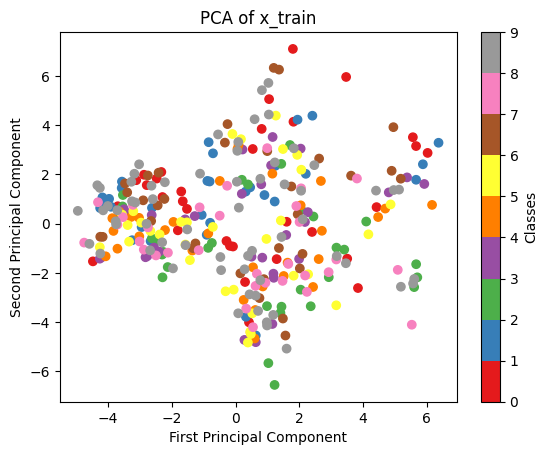

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Create a scatter plot of the first two principal components
scatter = plt.scatter(pca_x_train[:, 0], pca_x_train[:, 1], c=y_train, cmap=cm.Set1)

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Classes')

# Add a title and labels
plt.title('PCA of x_train')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Show the plot
plt.show()